In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from typing import Callable

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

2024-05-27 13:06:56.455989: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 13:06:56.458023: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 13:06:56.486857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 13:06:57.054516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Input Features Preparation

* **Technical Indicators**:
    * Simple Moving Average (SMA)
    * Exponential Moving Average (EMA)
    * Relative Strength Index (RSI)
    * Moving Average Convergence Divergence (MACD)

* **"Lagged" Features**:
    * Lagged Close Prices (close price values from previous days)
    * Lagged Returns (percentage in return in a given time frame up to "now")

* **Date Features**
    * Day of the Week
    * Day of the Month


In [2]:
import dataclasses

@dataclasses.dataclass
class TickerMetadata:
    start_date: str
    end_date: str
    n_days_lag: int
    n_epochs: int
    batch_size: int

In [3]:
def SMA(close_price: pd.Series, n_periods: int) -> pd.Series:
    """
    Standard Moving Average
    """
    return close_price.rolling(window=n_periods, min_periods=1).mean()

In [4]:
def EMA(close_price: pd.Series, n_periods: int) -> pd.Series:
    """
    Exponential Moving Average
    """
    return close_price.ewm(span=n_periods, adjust=False).mean()

In [5]:
def RSI(close_price: pd.Series, n_periods: int, average) -> pd.Series:
    """
    Relative Strength Index

    RSI is a "momentum indicator", it measures the oversolod / overbought level of a given asset.
    """

    delta = close_price.diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    gain_average = average(gain, n_periods)
    loss_average = average(loss, n_periods)

    rs = gain_average / loss_average
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [6]:
def MACD(close_price: pd.Series) -> pd.Series:
    """
    Moving Average Convergence Divergence
    """
    return EMA(close_price, n_periods=12) - EMA(close_price, n_periods=26)

In [7]:
def calculate_training_examples(close_price: pd.Series, n_days_lag: int) -> tuple[pd.DataFrame, pd.DataFrame]:

    result = pd.DataFrame(index=close_price.index, data=close_price.values, columns=['Close'])

    # add 20 & 125 days moving average
    result['SMA_20'] = SMA(close_price, n_periods=20)
    result['SMA_125'] = SMA(close_price, n_periods=125)

    # add exponential moving average
    result['EMA_20'] = EMA(close_price, n_periods=20)
    result['EMA_125'] = EMA(close_price, n_periods=125)

    # add two kinds of RSI indicator
    result['RSI_SMA_14'] = RSI(close_price, n_periods=14, average=SMA)
    result['RSI_EMA_14'] = RSI(close_price, n_periods=14, average=EMA)

    # add MACD indicator
    result['MACD'] = MACD(close_price)

    # add previous close prices and returns
    returns = result['Close'].pct_change()
    for n_days in range(1, n_days_lag + 1):
        result[f'Price_Lag_{n_days}'] = close_price.shift(n_days)
        result[f'Returns_Lag_{n_days}'] = returns.shift(n_days)

    # add info about the days
    result['Day_of_Week'] = close_price.index.dayofweek
    result['Day_of_Month'] = close_price.index.day
    result['Month'] = close_price.index.month

    result = result.dropna()
    
    return result.drop(columns=['Close']), result['Close']

In [8]:

def get_ticker_data(ticker: str, start_date: str, end_date: str, n_days_lag: int) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    data = yf.download(ticker, start=start_date, end=end_date, progress=False).dropna()
    X, y = calculate_training_examples(close_price=data['Close'], n_days_lag=n_days_lag)
    # we want to predict the price of the stock at day d based on the data up to a day d-1, so we need to shift the data a little bit
    X, y = X.shift(-1).dropna(), y.iloc[1:]
    date_idx = y.index
    # I will treat X as a set of features calculated based on the data up to a previous day
    X, y = X.reset_index(drop=True), y.reset_index(drop=True)
    assert len(X.index) == len(y.index), 'index lengths do not match!'
    assert np.all(X.index == y.index), 'indices are different!'

    return X, y, date_idx



## Building and training the model

In [9]:
def train_model(training_data: dict, scalers: dict, ticker_name: str, n_epochs: int = 50, batch_size: int = 64):
    """
    Training tf.Sequential prediction model on given training data
    """

    X, y, _ = training_data[ticker_name]

    scaler = scalers[ticker_name]
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=123)

    # build the model
    model = Sequential()
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))

    # compile it
    model.compile(optimizer='adam', loss='mean_squared_error')

    # train it
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
    return model

In [10]:
def plot_training_stats(prediction_models: dict, n_cols: int = 3) -> None:
    # I am assuming, that all models are trained and have saved history
    n_plots = len(prediction_models)
    n_rows = int(np.ceil(n_plots / n_cols))
    figure, axis = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(9*n_cols, 6*n_rows))
    tickers = list(prediction_models.keys())
    for ax_idx, ax in enumerate(axis.flatten()):
        if ax_idx > len(tickers) - 1:
            break
        ticker = tickers[ax_idx]
        model = prediction_models[ticker]
        ax.plot(model.history.history['loss'], label='Training Loss')
        ax.plot(model.history.history['val_loss'], label='Validation Loss')
        ax.set_title(f'{ticker} Training: Losses Over Epochs')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Mean Squared Error')
        ax.legend()
    
    figure.suptitle('Training Stats', size=24)
    figure.show()

## Let's build prediction models for couple of stocks

In [11]:
tickers = ["AAPL", "AMZN", "NVDA", "META", "GOOG", "MSFT"]

### Set metadata to specify training parameters and featurer parameters for each ticker

In [12]:
metadata = {
    "AAPL": TickerMetadata(start_date="2010-12-12", end_date="2023-01-01", n_days_lag=5, n_epochs=150, batch_size=32),
    "AMZN": TickerMetadata(start_date="2010-12-12", end_date="2023-01-01", n_days_lag=5, n_epochs=150, batch_size=64),
    "NVDA": TickerMetadata(start_date="2010-12-12", end_date="2023-01-01", n_days_lag=5, n_epochs=150, batch_size=32),
    "META": TickerMetadata(start_date="2010-12-12", end_date="2023-01-01", n_days_lag=5, n_epochs=150, batch_size=32),
    "GOOG": TickerMetadata(start_date="2010-12-12", end_date="2023-01-01", n_days_lag=5, n_epochs=150, batch_size=64),
    "MSFT": TickerMetadata(start_date="2010-12-12", end_date="2023-01-01", n_days_lag=5, n_epochs=150, batch_size=64),
}

### Download data from yfinance and compute input features

In [13]:
# compute training data
training_data = dict()
for ticker in tickers:
    ticker_metadata = metadata[ticker]
    training_data[ticker] = get_ticker_data(ticker, start_date=ticker_metadata.start_date, end_date=ticker_metadata.end_date, n_days_lag=ticker_metadata.n_days_lag)

### StandardScaler instance for each model separately (very important!)

In [14]:
scalers = {ticker: StandardScaler() for ticker in tickers}

### Prediction models training

In [15]:
# train models
prediction_models = dict()
for ticker in tickers:
    prediction_models[ticker] = train_model(training_data=training_data, scalers=scalers, ticker_name=ticker, n_epochs=metadata[ticker].n_epochs, batch_size=metadata[ticker].batch_size)

### Training stats

In [16]:
plot_training_stats(prediction_models, n_cols=3)

/tmp/ipykernel_460980/2417239986.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


### Prediction models performance test (on historical stock prices from 2023)
Explanation: Prediction for n days ahead (n-days timeframe) can be computed (on historical data!) by composing prediction procedure n-times on the historical data.

In [17]:
def predict_prices(ticker: str, prediction_models: dict, scalers: dict, ticker_metadata: TickerMetadata, start_date: str, end_date: str, timeframe: int = 1) -> tuple[pd.Series, pd.Series]:
    X, y, date_idx = get_ticker_data(ticker, start_date, end_date, n_days_lag=ticker_metadata.n_days_lag)
    for _ in range(timeframe):
        X_scaled = scalers[ticker].transform(X)
        y_hat = prediction_models[ticker].predict(X_scaled, verbose=0).reshape(-1, )
        y_hat = pd.Series(data=y_hat, index=date_idx[len(y) - len(y_hat):])
        X, _ = calculate_training_examples(y_hat, ticker_metadata.n_days_lag)
    
    return pd.Series(data=y.values.reshape(-1, )[len(y) - len(y_hat):], index=y_hat.index), y_hat


In [18]:
def plot_predictions(predictions: dict, timeframes: list[int]) -> None:
    n_rows = len(predictions)
    n_cols = len(timeframes)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(9*n_cols, 6*n_rows))

    for row_idx, (ticker_name, ticker_predictions) in enumerate(predictions.items()):
        for col_idx, timeframe in enumerate(timeframes):
            y, y_hat = ticker_predictions[timeframe]
            ax = axes[row_idx, col_idx]
            ax.plot(y, label='price')
            ax.plot(y_hat, label='prediction')
            ax.set_title(f'{ticker_name}: {timeframe} Days Timeframe')
            ax.set_xlabel('date')
            ax.set_ylabel('price [$]')
            ax.legend()
    
    fig.suptitle('Price Prediction')
    fig.tight_layout()
    fig.show()

In [19]:
def prediction_err(prediction: dict, mean_err_func: Callable[[pd.Series, pd.Series], float]) -> dict:
    result = dict()
    for ticker, ticker_predictions in prediction.items():
        result[ticker] = dict()
        result[ticker]['X'] = np.array(list(ticker_predictions.keys()))
        result[ticker]['y'] = np.array([mean_err_func(y, y_hat) for y, y_hat in ticker_predictions.values()])
    return result

In [20]:
def plot_err(data_to_plot: dict, err: str, n_cols: int = 3) -> None:

    for ticker, ticker_data in data_to_plot.items():
        plt.scatter(ticker_data['X'], ticker_data['y'], label=ticker)
    plt.legend()
    plt.xlabel('prediction timeframe [days]')
    plt.ylabel(err)
    plt.title(f'Mean Error')
    plt.tight_layout()
    plt.show()
        

In [21]:
def prediction_ptwise_err(prediction: dict[dict[str, tuple[pd.Series, pd.Series]]], err_ptwise_func: Callable[[pd.Series, pd.Series], pd.Series]) -> dict:
    result = dict()
    for ticker, ticker_predictions in prediction.items():
        result[ticker] = dict()
        for timeframe, (y, y_hat) in ticker_predictions.items():
            result[ticker][timeframe] = err_ptwise_func(y, y_hat)
    
    return result

In [22]:
def plot_ptws_err_dist(data_to_plot: dict, err: str, timeframes: list[int]) -> None:
    # row per ticker
    n_rows = len(data_to_plot)
    # columnt per timeframe
    n_cols = len(timeframes)
    # create grid for plotting
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(9 * n_cols, 6 * n_rows))

    for row_idx, (ticker_name, ticker_data) in enumerate(data_to_plot.items()):
        for col_idx, timeframe in enumerate(timeframes):
            ax = axes[row_idx, col_idx]
            sns.histplot(ticker_data[timeframe].values, bins=50, kde=True, ax=ax)
            ax.set_title(f'{ticker_name}: {timeframe} Days Timeframe')
            ax.set_xlabel(err)
            ax.set_ylabel('frequency')
    
    fig.tight_layout()
    fig.show()


### Price prediction 

In [23]:
# prediction aquracy will be tested for diffrent timeframes (day ahead, two days ahead and so on...
prediction_timeframes = list(range(1, 16))

In [24]:
predictions = dict()
for idx, ticker in enumerate(tickers):
    print(f"Predicting prices for ticker {ticker}...")
    predictions[ticker] = dict()
    for timeframe in prediction_timeframes:
        predictions[ticker][timeframe] = predict_prices(ticker, prediction_models, scalers, metadata[ticker], start_date='2023-01-01', end_date='2024-05-23', timeframe=timeframe)
    print(f"Predicting prices for ticker {ticker} - Done ({idx + 1}/{len(tickers)}).")


Predicting prices for ticker AAPL...
Predicting prices for ticker AAPL - Done (1/6).
Predicting prices for ticker AMZN...
Predicting prices for ticker AMZN - Done (2/6).
Predicting prices for ticker NVDA...
Predicting prices for ticker NVDA - Done (3/6).
Predicting prices for ticker META...
Predicting prices for ticker META - Done (4/6).
Predicting prices for ticker GOOG...
Predicting prices for ticker GOOG - Done (5/6).
Predicting prices for ticker MSFT...
Predicting prices for ticker MSFT - Done (6/6).


In [25]:
plot_predictions(predictions, timeframes=[1, 3, 5, 8])

/tmp/ipykernel_460980/4186506333.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


### Mean Absolute Percentage Error

In [26]:
prediction_abs_pct_err = prediction_err(predictions, lambda s1, s2: np.round(mean_absolute_percentage_error(s1, s2) * 100, decimals=2))

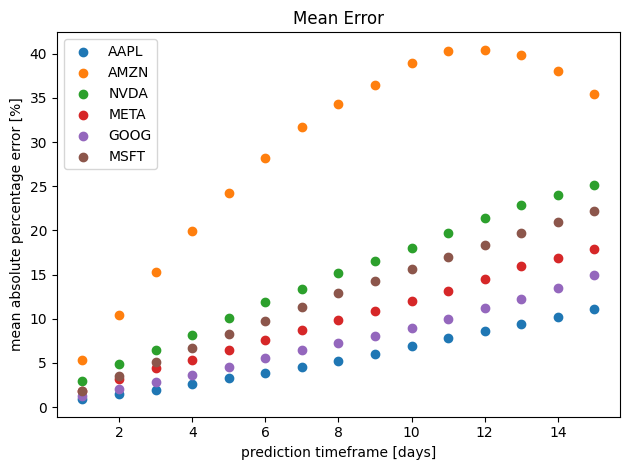

In [27]:
plot_err(prediction_abs_pct_err, err='mean absolute percentage error [%]')

### Absolute Percentage Error Distribution

In [28]:
prediction_ptwise_abs_pct_err = prediction_ptwise_err(predictions, lambda s1, s2: np.round(np.abs(s1 - s2) * 100 / s1, decimals=2))

In [29]:
plot_ptws_err_dist(prediction_ptwise_abs_pct_err, err='absolute precentage error [%]', timeframes=[1, 3, 5, 10])

/tmp/ipykernel_460980/1230018524.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


### Stock momentum

Since we are trying to predict the behaviour of a stock, we can validate if our prediction models are good in identifying ups and downs. We can do it by applying very simple metric. Assume, that historical known price $p$ and its prediction $\hat{p}$ indexed by a time index $t$ is given. We can define the up-down metric as follows:

\begin{align}
d_{up, down}(p_t, \hat{p}_t) = \hbox{sign}\left((p_{t-1} - p_t)\cdot(\hat{p}_t - \hat{p}_{t-1})\right),
\end{align}

where the $\hbox{sign}$ function is $1$ for positive arguments (stock price is different for any two consecitive days) and zero otherwise. Let's try to find out how the mean error for different tickers changes as timeframe varies.

In [30]:
def price_movement_prediction_err(s1: pd.Series, s2: pd.Series) -> float:
    diff1 = s1.diff().dropna()
    diff2 = s2.diff().dropna()

    mean_err = (1 - np.maximum(0, np.sign(diff1 * diff2))).mean() * 100
    return mean_err

In [31]:
plot_err(data_to_plot=prediction_err(predictions, price_movement_prediction_err), err='price movement prediction error [%]', n_cols=3)

### Prediction and stock price correlation

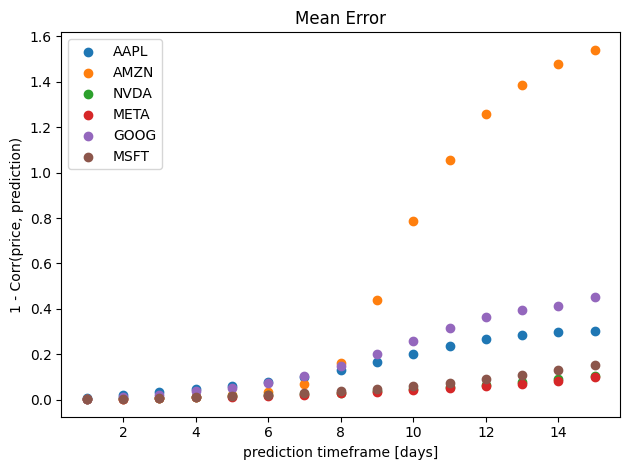

In [32]:
plot_err(data_to_plot=prediction_err(predictions, lambda s1, s2: 1 - s1.corr(s2)), err='1 - Corr(price, prediction)', n_cols=3)